In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental import RandomFourierFeatures

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, LayerNormalization, ConvLSTM2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
data_file = "/kaggle/input/messidor2preprocess/messidor_data.csv"
data = pd.read_csv(data_file)

data.head()

,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


In [3]:
img_names = data['id_code'].values
dr_labels = data['diagnosis'].values
dme_labels = data['adjudicated_dme'].values

In [4]:
# Task Name
task_name = "Diabetic Macular Edema Severity Grading"

# Desired image dimensions
IMAGE_SIZE = (224, 224)
image_size = (224, 224, 3)


#directory_path
dir_path = "/kaggle/input/messidor2preprocess/messidor-2/messidor-2/preprocess/"

#Process Image Paths
img_paths = list(dir_path+img_name for img_name in img_names)


#List of categories, types & grades
dr = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
dme = ['No Referable DME','Referable DME']

num_dr = len(dr)
num_dme = len(dme)

#Batch Size
BATCH_SIZE = 64

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

#Epochs
EPOCHS = 50

In [5]:
# train test split
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels1, test_labels1 = train_test_split(img_paths, to_categorical(dr_labels), test_size=0.2, random_state=2)
train_imgs, test_imgs, train_labels2, test_labels2 = train_test_split(img_paths, to_categorical(dme_labels), test_size=0.2, random_state=2)

In [6]:
def process_images(img_path, label1, label2):
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label1, label2

# Prepare Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels1, train_labels2))
train_ds = train_ds.map(process_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# Prepare Testing Dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels1, test_labels2))
test_ds = test_ds.map(process_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [7]:
X_train = np.array([imgs.numpy() for imgs, _, _ in train_ds.unbatch()])
y_train1 = np.array([labels.numpy() for _, labels, _ in train_ds.unbatch()])
y_train2 = np.array([labels.numpy() for _, _, labels in train_ds.unbatch()])

X_test = np.array([imgs.numpy() for imgs, _, _ in test_ds.unbatch()])
y_test1 = np.array([labels.numpy() for _, labels, _ in test_ds.unbatch()])
y_test2 = np.array([labels.numpy() for _, _, labels in test_ds.unbatch()])

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

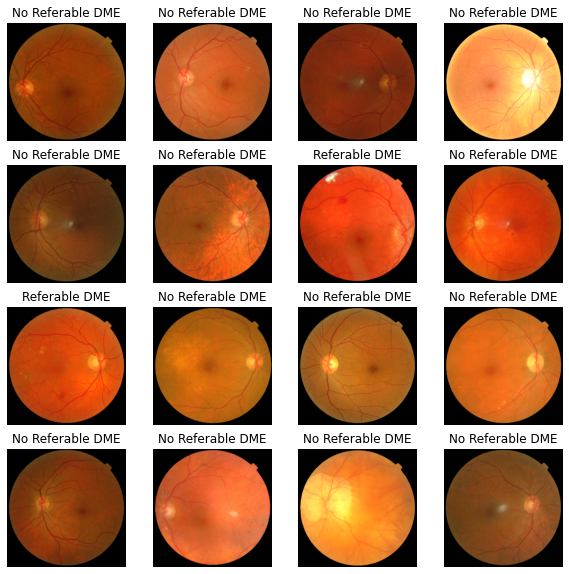

In [19]:
# Map the disease categories
mapping = { 0:'No Referable DME', 1:'Referable DME'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(zca_whitening=True,
                              #rotation_range=15,
                              #zoom_range=0.15,
                              #width_shift_range=0.2,
                              #brightness_range=(.6, 1.2),
                              #shear_range=.15,
                              #height_shift_range=0.2,
                              #horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(x = X_train, y = y_train2, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [9]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextBlock(ip, reduction_ratio=8, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [10]:
def SpatialAttention(fmaps):
    SA_A = tf.reduce_mean(fmaps,[0,3],keepdims=True) # Depth-wise Average Pooling
    Conv_A = Conv2D(1,3,activation='sigmoid',padding="same")(SA_A) # Apply Softmax based gated attention on Average-Spatial Map
    sa_fmaps = Multiply()([fmaps,Conv_A]) # multiply all feature maps with average spatial attention map
    return sa_fmaps

def ChannelAttention(fmaps):
    GAP = GlobalAveragePooling2D()(fmaps)
    FC1 = Dense(fmaps.shape[3]//8, activation='tanh')(GAP)
    FC2 = Dense(fmaps.shape[3], activation='sigmoid')(FC1)
    ca_fmaps = Multiply()([fmaps,FC2])
    return ca_fmaps

def GatedAttention(fmaps):
    fmaps = tf.expand_dims(fmaps, axis=1)
    maps = ConvLSTM2D(filters=(fmaps.shape[-1]//8),kernel_size=(3,3),activation="tanh",padding="same",return_sequences=True)(fmaps)
    g_maps = ConvLSTM2D(filters=fmaps.shape[-1],kernel_size=(3,3),activation="sigmoid",padding="same",return_sequences=True)(maps)
    g_maps = tf.squeeze(g_maps, axis=1)
    return g_maps
    

def build_model():
    
    inputs = Input(shape=image_size)
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable=False
    fmaps = base_model.get_layer('block4_pool').output
    
    #Add Spatial Attention Layer
    sa_fmaps = SpatialAttention(fmaps)
    sa_fmaps = LayerNormalization()(sa_fmaps)
    
    SA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Add Channel Attention Layer
    ca_fmaps = ChannelAttention(fmaps)
    ca_fmaps = LayerNormalization()(ca_fmaps)
    
    CA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Residual Addition
    res1 = Add()([ca_fmaps, sa_fmaps])
    res1 = LayerNormalization()(res1)
    
    GAP = GlobalAveragePooling2D()(fmaps) # Squeeze average maps
    
    #Add Global-Context Attention Layer
    gc_fmaps = GlobalContextBlock(fmaps)
    gc_fmaps = LayerNormalization()(gc_fmaps)
    
    GC_GAP = GlobalAveragePooling2D()(gc_fmaps) # Squeeze average maps
    
    #Residual Addition
    res2 = Add()([gc_fmaps, res1])
    res2 = LayerNormalization()(res2)
    
    #Add Gated Attention Layer
    g_maps = GatedAttention(fmaps)
    g_maps = LayerNormalization()(g_maps)
    
    G_GAP = GlobalAveragePooling2D()(g_maps) # Squeeze average maps
    
    #Residual Addition
    res3 = Add()([g_maps, res2])
    res3 = LayerNormalization()(res3)
    
    R_GAP = GlobalAveragePooling2D()(res3) # Squeeze average maps
    
    #Fusion Layer
    fused_fmaps = Concatenate()([GAP, SA_GAP, CA_GAP, GC_GAP])
    LN = LayerNormalization()(fused_fmaps)
    
    outputs = Dense(2, activation='softmax')(fused_fmaps)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#Adam(learning_rate=1e-3)

    return model

# Create an object of the model
model = build_model()

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
# Create an object of the model
model = build_model()

from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

EPOCHS = 100
batch_size = 64
filepath = "/kaggle/working/dme_classifier.h5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop, earlystopping]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(X_train, y_train2, batch_size=batch_size,
                 validation_data=(X_test, y_test2),epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
22/22 [==============================] - 24s 485ms/step - loss: 4.5301 - accuracy: 0.8272 - val_loss: 1.2560 - val_accuracy: 0.8338

Epoch 00001: val_accuracy improved from -inf to 0.83381, saving model to /kaggle/working/dme_classifier.h5
Epoch 2/100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


22/22 [==============================] - 3s 149ms/step - loss: 1.6619 - accuracy: 0.8609 - val_loss: 1.1366 - val_accuracy: 0.9169

Epoch 00002: val_accuracy improved from 0.83381 to 0.91691, saving model to /kaggle/working/dme_classifier.h5
Epoch 3/100
22/22 [==============================] - 3s 149ms/step - loss: 1.1073 - accuracy: 0.8552 - val_loss: 0.9172 - val_accuracy: 0.8625

Epoch 00003: val_accuracy did not improve from 0.91691
Epoch 4/100
22/22 [==============================] - 3s 154ms/step - loss: 0.8608 - accuracy: 0.8867 - val_loss: 0.9022 - val_accuracy: 0.8539

Epoch 00004: val_accuracy did not improve from 0.91691
Epoch 5/100
22/22 [==============================] - 3s 151ms/step - loss: 0.6675 - accuracy: 0.8918 - val_loss: 0.7058 - val_accuracy: 0.9341

Epoch 00005: val_accuracy improved from 0.91691 to 0.93410, saving model to /kaggle/working/dme_classifier.h5
Epoch 6/100
22/22 [==============================] - 3s 150ms/step - loss: 0.7603 - accuracy: 0.8774 - val

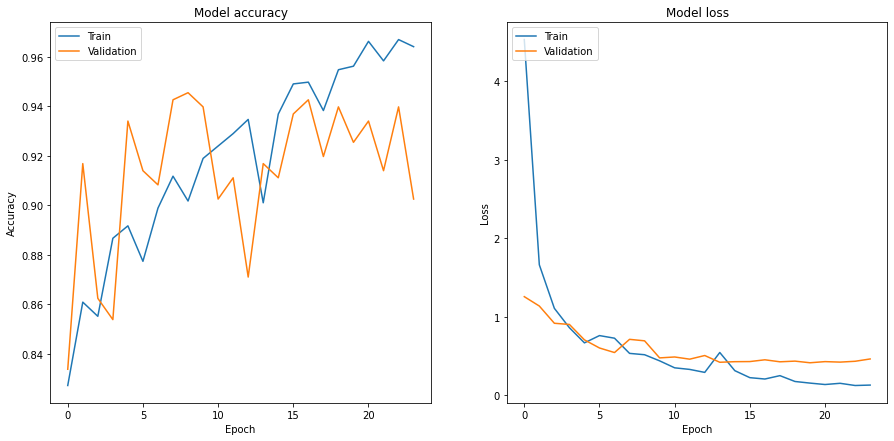

In [12]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [13]:
model = load_model(filepath)
model.evaluate(X_test, y_test2)

11/11 [==============================] - 4s 61ms/step - loss: 0.6932 - accuracy: 0.9456


[0.6931570768356323, 0.9455587267875671]

In [14]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=-1)
y_test = np.argmax(y_test2, axis=-1)

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(y_test,y_pred)
mpre = precision_score(y_test,y_pred,average='macro')
mrecall = recall_score(y_test,y_pred,average='macro')
mf1 = f1_score(y_test,y_pred,average='macro')
kappa = cohen_kappa_score(y_test,y_pred,weights='quadratic')
auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
print("ROC AUC Score: ",round(auc*100,2))

Accuracy:  94.56
Macro Precision:  89.04
Macro Recall:  60.72
Macro F1-Score:  65.82
Quadratic Kappa Score:  32.65
ROC AUC Score:  60.72


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4, target_names = dme))

                  precision    recall  f1-score   support

No Referable DME     0.9475    0.9969    0.9716       326
   Referable DME     0.8333    0.2174    0.3448        23

        accuracy                         0.9456       349
       macro avg     0.8904    0.6072    0.6582       349
    weighted avg     0.9400    0.9456    0.9303       349



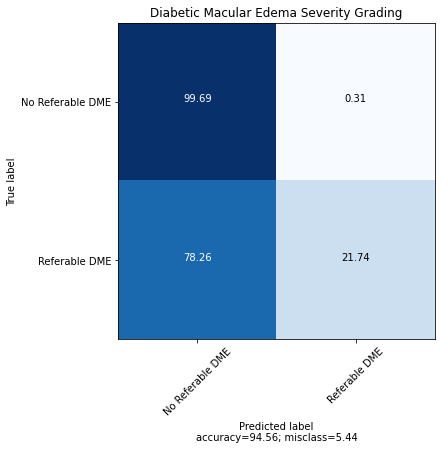

In [16]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy*100, misclass*100))
    plt.show()


# plot confusion matrix
cm = confusion_matrix(y_test,y_pred)
targets = dme
plot_confusion_matrix(cm, target_names = targets, title=task_name, cmap='Blues', normalize=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


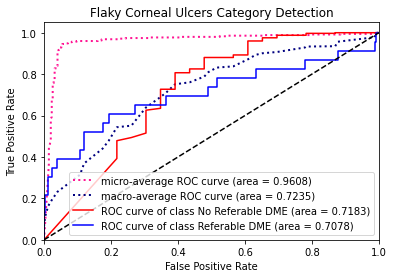

In [17]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['red','blue','green','darkorange', 'purple', 'cyan', 'violet', 'peru', 'black', 'gold'])
classes = dme
lw = 1.5

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Flaky Corneal Ulcers Category Detection')
plt.legend(loc="lower right")
plt.show()